# Анализ данных из файла 'Kuiper.xls'

В данном ноутбуке проводится анализ данных из набора `Kuiper.xls`, включающий переменные `Price`, `Mileage`, `Cylinder`, `Liter`, `Cruise`. Выполним последовательные шаги для корреляционного анализа, построения модели линейной регрессии, проверки значимости, анализа выбросов, и улучшения модели.

## Загрузка данных

In [9]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from scipy.stats import boxcox

# Определение названий столбцов
column_names = ['Brand', 'Feature1', 'Feature2', 'Feature3', 'Feature4']

# Чтение файла с использованием разделителей пробелами
data = pd.read_csv(
    'data/cigarettes.dat.txt',
    delim_whitespace=True,  # Использовать пробелы как разделители
    header=None,            # Файл не содержит заголовков
    names=column_names      # Назначение имен столбцам
)

#Features = carbon monoxide, tar, nicotine, weight
data.columns = ['Brand', 'CO', 'Tar', 'Nicotine', 'Weight']
data = data.drop('Brand', axis=1)

# Отображение первых 5 строк DataFrame для проверки
data.head()

C:\Users\stepa\AppData\Local\Temp\ipykernel_6088\145879018.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


,CO,Tar,Nicotine,Weight
0,14.1,0.86,0.9853,13.6
1,16.0,1.06,1.0938,16.6
2,29.8,2.03,1.1650,23.5
3,8.0,0.67,0.9280,10.2
4,4.1,0.40,0.9462,5.4


## Шаг 1: Корреляционный анализ

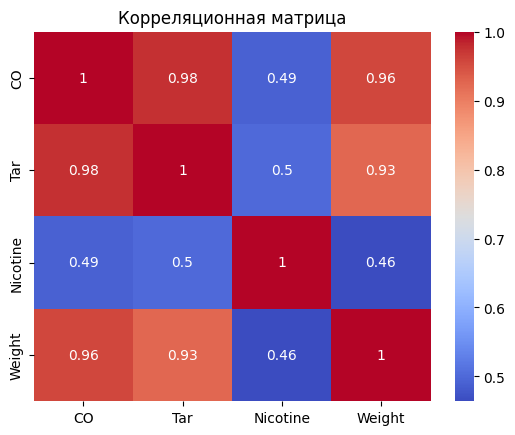

In [10]:
# Проведение корреляционного анализа
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

## Шаг 2: Базовая модель линейной регрессии

In [11]:
# Построение базовой модели линейной регрессии
X = data.drop('CO', axis=1)
y = data['CO']
X = add_constant(X)  # Добавление константы

model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CO   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     258.3
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           9.95e-17
Time:                        18:05:22   Log-Likelihood:                -32.889
No. Observations:                  25   AIC:                             73.78
Df Residuals:                      21   BIC:                             78.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3696      2.347     -1.010      0.324      -7.251       2.512
Tar           10.0803      1.537      6.560      0.000       6.885      13.276
Nicotine       0.1704      2.644      0.064      0.949      -5.328       5.669
Weight         0.4459      0.112      3.974      0.001       0.213       0.679
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.494
Skew:                           0.201   Prob(JB):                        0.781
Kurtosis:                       2.441   Cond. No.                         241.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Шаг 3: Уравнение линейной регрессии

In [12]:

# Вывод уравнения регрессии
coefficients = model.params
equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine + {coefficients[3]:.2f}*Weight"
print("Уравнение линейной регрессии:")
print(equation)


Уравнение линейной регрессии:
CO = -2.37 + 10.08*Tar + 0.17*Nicotine + 0.45*Weight


C:\Users\stepa\AppData\Local\Temp\ipykernel_6088\3072229313.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine + {coefficients[3]:.2f}*Weight"


## Шаг 4: Проверка значимости коэффициентов с помощью T-теста

In [13]:
# Проверка значимости каждого коэффициента
print(model.t_test(np.eye(len(model.params))))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -2.3696      2.347     -1.010      0.324      -7.251       2.512
c1            10.0803      1.537      6.560      0.000       6.885      13.276
c2             0.1704      2.644      0.064      0.949      -5.328       5.669
c3             0.4459      0.112      3.974      0.001       0.213       0.679


## Шаг 5: Проверка значимости уравнения регрессии с помощью F-теста

In [14]:
# Проведение F-теста
f_stat = model.fvalue
f_pvalue = model.f_pvalue
print(f'F-статистика: {f_stat}, p-значение: {f_pvalue}')

F-статистика: 258.2589591316706, p-значение: 9.949064852223963e-17


## Шаг 6: График рассеяния и уравнение регрессии

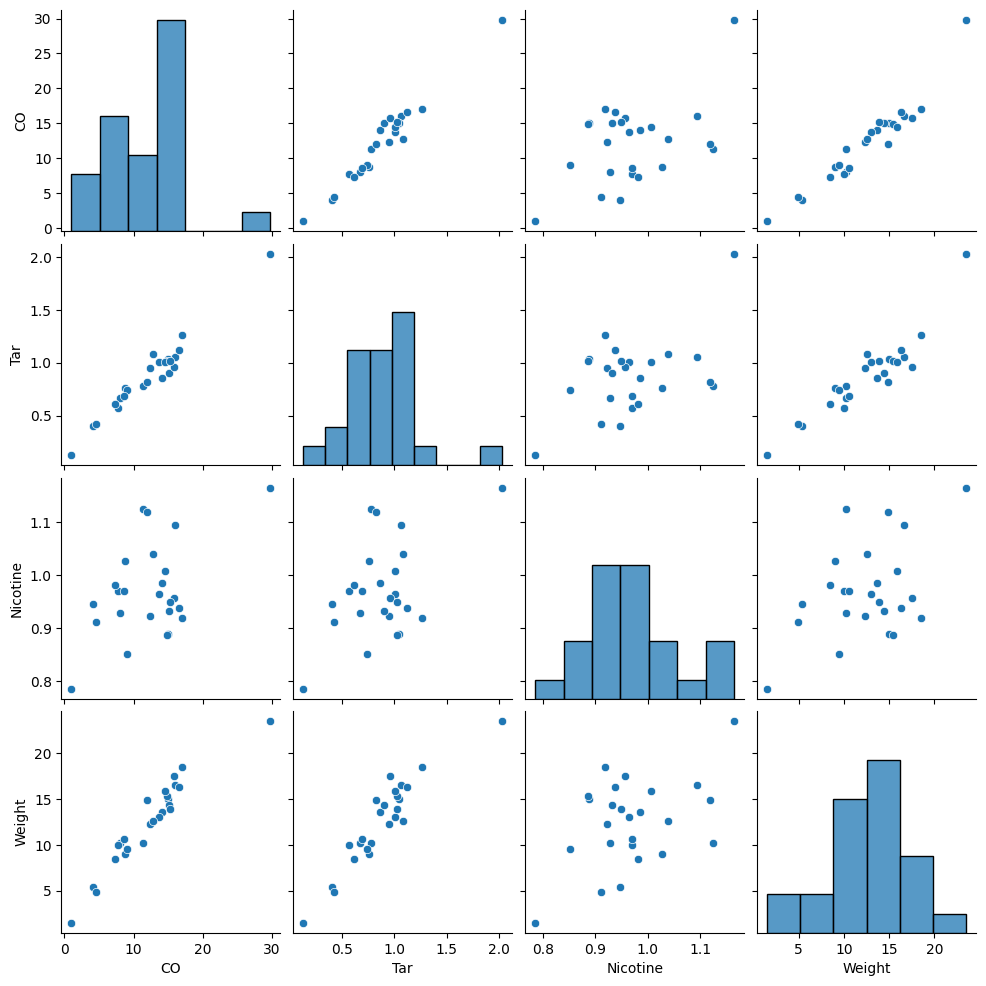

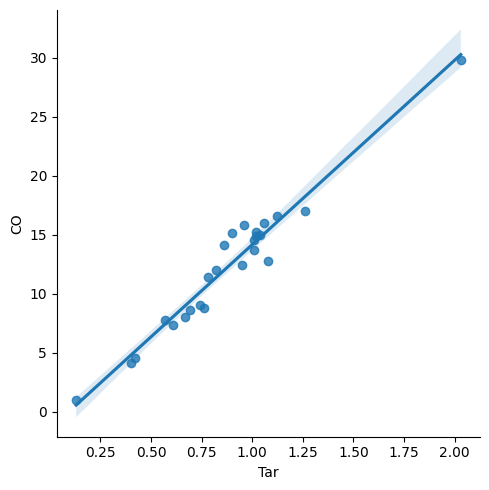

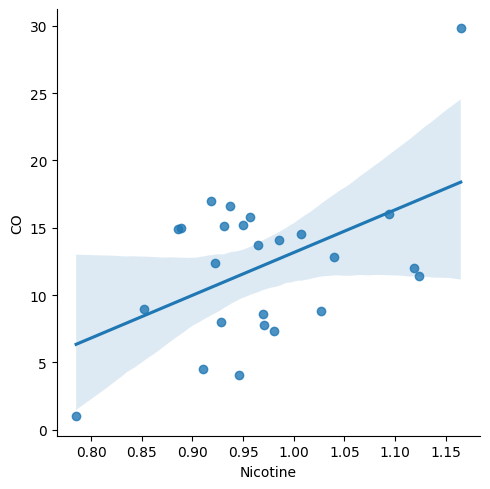

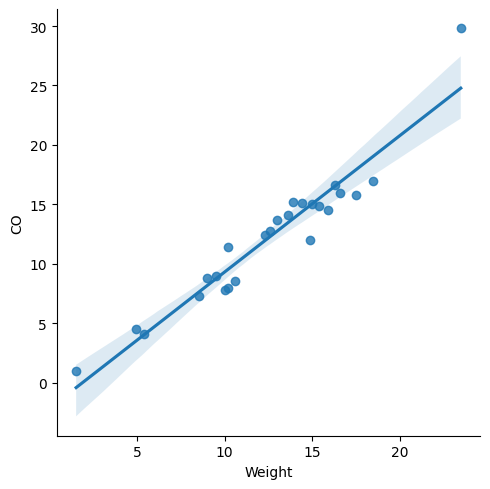

In [16]:
# Построение графиков рассеяния
sns.pairplot(data)
#Построение уравнений регрессии с коэффициентами из модели
sns.lmplot(x='Tar', y='CO', data=data)
sns.lmplot(x='Nicotine', y='CO', data=data)
sns.lmplot(x='Weight', y='CO', data=data)


plt.show()

## Шаг 7: Доверительные интервалы для коэффициентов регрессии

In [17]:
# Построение доверительных интервалов
conf_intervals = model.conf_int()
print('Доверительные интервалы для коэффициентов:')
print(conf_intervals)

Доверительные интервалы для коэффициентов:
                 0          1
const    -7.251016   2.511847
Tar       6.884585  13.276023
Nicotine -5.328344   5.669223
Weight    0.212517   0.679218


## Шаг 8: Проверка на наличие выбросов

In [18]:
# Проверка на важные наблюдения
influence = model.get_influence()
summary_influence = influence.summary_frame()

"""Интерпритация результатов:
cooks_d - показывает влиятельность наблюдения на модель. Чем больше значение, тем более влиятельно наблюдение.
standard_resid - стандартизированные остатки. Если значение больше 3, то наблюдение считается важным.
hat_diag - диагональные элементы матрицы влиятельности. Если значение больше 2 * (кол-во факторов + 1) / кол-во наблюдений, то наблюдение считается важным.
"""

#Важные наблюдения
important_observations = summary_influence[summary_influence['cooks_d'] > 4/len(data)]

# Вычисление стандартизированных остатков
standard_resid = summary_influence['standard_resid']

# Идентификация выбросов в important_observations
outliers = important_observations[important_observations['standard_resid'] > 3]
print("Выбросы по стандартизированным остаткам:")
outliers

Выбросы по стандартизированным остаткам:


,dfb_const,dfb_Tar,dfb_Nicotine,dfb_Weight,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


In [19]:
#Удаление выбросов
data = data.drop(outliers.index)

In [20]:
#Модель без выбросов
X = data.drop('CO', axis=1)
y = data['CO']
X = add_constant(X)

model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CO   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     258.3
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           9.95e-17
Time:                        18:07:07   Log-Likelihood:                -32.889
No. Observations:                  25   AIC:                             73.78
Df Residuals:                      21   BIC:                             78.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3696      2.347     -1.010      0.324      -7.251       2.512
Tar           10.0803      1.537      6.560      0.000       6.885      13.276
Nicotine       0.1704      2.644      0.064      0.949      -5.328       5.669
Weight         0.4459      0.112      3.974      0.001       0.213       0.679
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.494
Skew:                           0.201   Prob(JB):                        0.781
Kurtosis:                       2.441   Cond. No.                         241.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___


## Шаг 9: Улучшение модели с помощью StepAIC

In [22]:
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def step_aic(X, y):
    while True:
        X_const = add_constant(X)
        model = OLS(y, X_const).fit()
        aic = model.aic
        
        # Вычисление VIF
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        
        # Поиск переменной с наибольшим VIF
        max_vif = vif_data["VIF"].max()
        if max_vif > 10:
            feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
            X = X.drop(columns=[feature_to_remove])
            print(f"Удален признак {feature_to_remove} из-за мультиколлинеарности (VIF={max_vif})")
        else:
            break
    return model

# Пример использования
X = data.drop('CO', axis=1)
y = data['CO']

final_model = step_aic(X, y)
print(final_model.summary())

Удален признак Weight из-за мультиколлинеарности (VIF=57.69439685677881)
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     226.9
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.06e-15
Time:                        18:07:30   Log-Likelihood:                -39.898
No. Observations:                  25   AIC:                             85.80
Df Residuals:                      22   BIC:                             89.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

___

In [23]:
data = pd.read_csv(
    'data/cigarettes.dat.txt',
    delim_whitespace=True,  # Использовать пробелы как разделители
    header=None,            # Файл не содержит заголовков
    names=column_names      # Назначение имен столбцам
)

#Features = carbon monoxide, tar, nicotine, weight
data.columns = ['Brand', 'CO', 'Tar', 'Nicotine', 'Weight']
data = data.drop('Brand', axis=1)
data = data.drop('Weight', axis=1)

# Отображение первых 5 строк DataFrame для проверки
data.head()

C:\Users\stepa\AppData\Local\Temp\ipykernel_6088\3101020479.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


,CO,Tar,Nicotine
0,14.1,0.86,0.9853
1,16.0,1.06,1.0938
2,29.8,2.03,1.1650
3,8.0,0.67,0.9280
4,4.1,0.40,0.9462


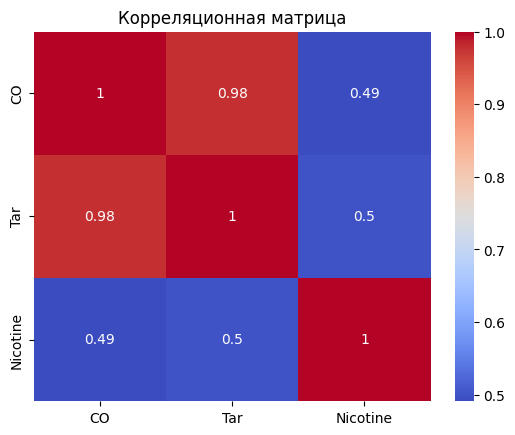

In [24]:
# Проведение корреляционного анализа
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

## Шаг 2: Базовая модель линейной регрессии

In [25]:
# Построение базовой модели линейной регрессии
X = data.drop('CO', axis=1)
y = data['CO']
X = add_constant(X)  # Добавление константы

model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CO   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     226.9
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.06e-15
Time:                        18:09:05   Log-Likelihood:                -39.898
No. Observations:                  25   AIC:                             85.80
Df Residuals:                      22   BIC:                             89.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6500      3.026     -0.545      0.591      -7.926       4.626
Tar           15.6038      0.847     18.419      0.000      13.847      17.361
Nicotine       0.1967      3.419      0.058      0.955      -6.894       7.288
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.316
Skew:                           0.274   Prob(JB):                        0.854
Kurtosis:                       2.938   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Шаг 3: Уравнение линейной регрессии

In [26]:

# Вывод уравнения регрессии
coefficients = model.params
equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine"
print(equation)


CO = -1.65 + 15.60*Tar + 0.20*Nicotine


C:\Users\stepa\AppData\Local\Temp\ipykernel_6088\4062636485.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine"


## Шаг 4: Проверка значимости коэффициентов с помощью T-теста

In [27]:
# Проверка значимости каждого коэффициента
print(model.t_test(np.eye(len(model.params))))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.6500      3.026     -0.545      0.591      -7.926       4.626
c1            15.6038      0.847     18.419      0.000      13.847      17.361
c2             0.1967      3.419      0.058      0.955      -6.894       7.288


## Шаг 5: Проверка значимости уравнения регрессии с помощью F-теста

In [28]:
# Проведение F-теста
f_stat = model.fvalue
f_pvalue = model.f_pvalue
print(f'F-статистика: {f_stat}, p-значение: {f_pvalue}')

F-статистика: 226.93776508422434, p-значение: 2.061685320594076e-15


## Шаг 6: График рассеяния и уравнение регрессии

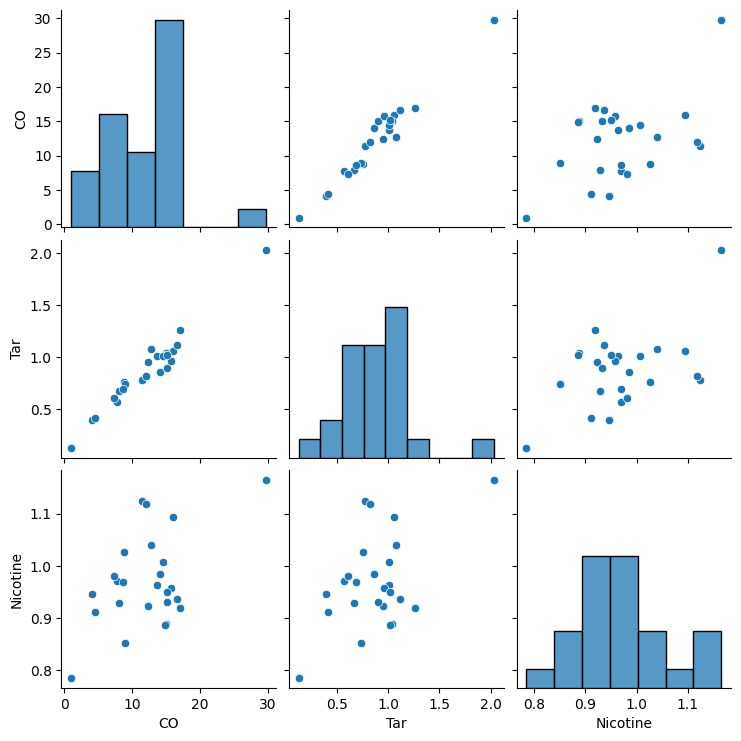

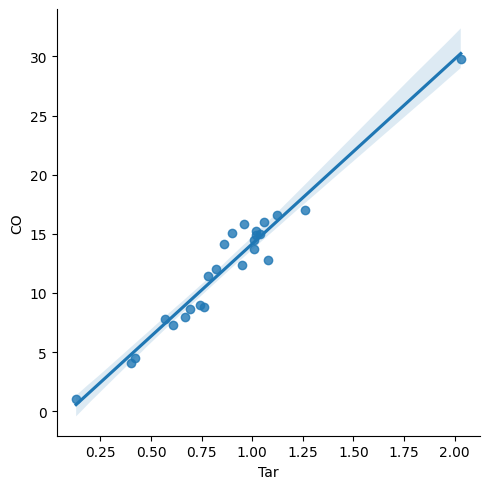

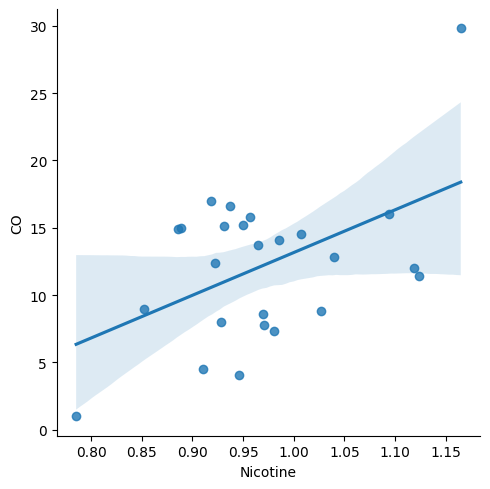

In [30]:
# Построение графиков рассеяния
sns.pairplot(data)
#Построение уравнений регрессии с коэффициентами из модели
sns.lmplot(x='Tar', y='CO', data=data)
sns.lmplot(x='Nicotine', y='CO', data=data)


plt.show()

## Шаг 7: Доверительные интервалы для коэффициентов регрессии

In [31]:
# Построение доверительных интервалов
conf_intervals = model.conf_int()
print('Доверительные интервалы для коэффициентов:')
print(conf_intervals)

Доверительные интервалы для коэффициентов:
                  0          1
const     -7.926199   4.626271
Tar       13.846874  17.360657
Nicotine  -6.894434   7.287770


## Шаг 8: Проверка на наличие выбросов

In [32]:
# Проверка на важные наблюдения
influence = model.get_influence()
summary_influence = influence.summary_frame()

"""Интерпритация результатов:
cooks_d - показывает влиятельность наблюдения на модель. Чем больше значение, тем более влиятельно наблюдение.
standard_resid - стандартизированные остатки. Если значение больше 3, то наблюдение считается важным.
hat_diag - диагональные элементы матрицы влиятельности. Если значение больше 2 * (кол-во факторов + 1) / кол-во наблюдений, то наблюдение считается важным.
"""

#Важные наблюдения
important_observations = summary_influence[summary_influence['cooks_d'] > 4/len(data)]

# Вычисление стандартизированных остатков
standard_resid = summary_influence['standard_resid']

# Идентификация выбросов в important_observations
outliers = important_observations[important_observations['standard_resid'] > 3]
print("Выбросы по стандартизированным остаткам:")
outliers

Выбросы по стандартизированным остаткам:


,dfb_const,dfb_Tar,dfb_Nicotine,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


In [33]:
#Удаление выбросов
data = data.drop(outliers.index)

In [34]:
#Модель без выбросов
X = data.drop('CO', axis=1)
y = data['CO']
X = add_constant(X)

model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CO   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     226.9
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.06e-15
Time:                        18:10:00   Log-Likelihood:                -39.898
No. Observations:                  25   AIC:                             85.80
Df Residuals:                      22   BIC:                             89.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6500      3.026     -0.545      0.591      -7.926       4.626
Tar           15.6038      0.847     18.419      0.000      13.847      17.361
Nicotine       0.1967      3.419      0.058      0.955      -6.894       7.288
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.316
Skew:                           0.274   Prob(JB):                        0.854
Kurtosis:                       2.938   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___

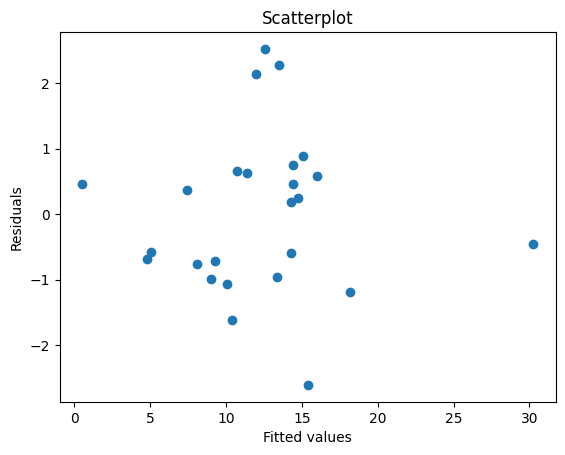

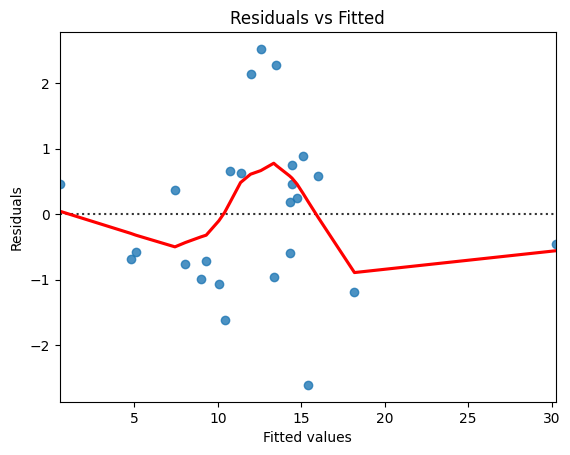

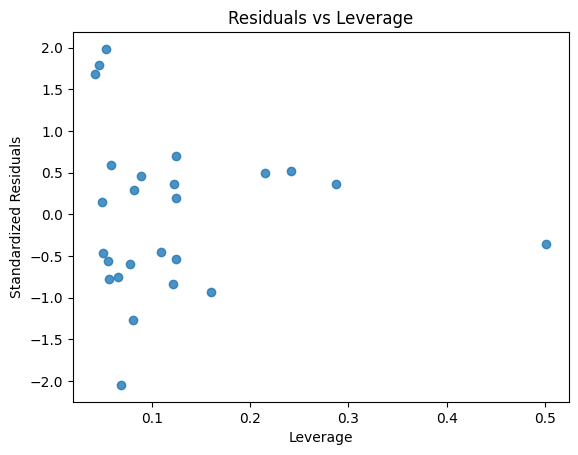

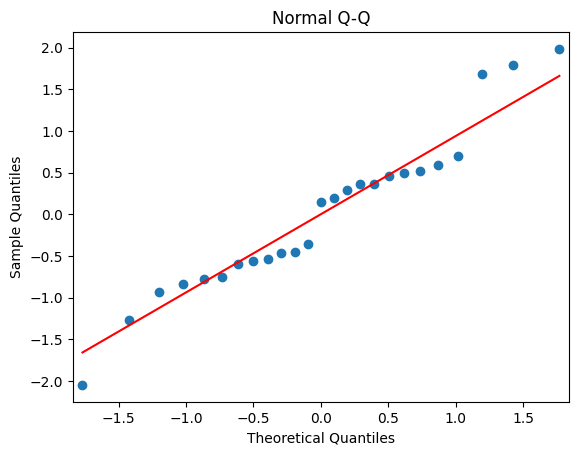

In [35]:
#Построим графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage"
# Scatterplot
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Scatterplot')
plt.show()

# Residuals vs Fitted
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Residuals vs Leverage
sns.regplot(x=model.get_influence().hat_matrix_diag, y=model.resid_pearson, fit_reg=False)
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')
plt.show()

# Normal Q-Q
qqplot(model.resid_pearson, line='s')
plt.title('Normal Q-Q')
plt.show()



In [36]:
# Проверка на гетероскедастичность
bp_test = het_breuschpagan(model.resid, X)

print(f'LM-статистика: {bp_test[0]}, p-значение: {bp_test[1]}')

# Проверка на автокорреляцию
bg_test = acorr_breusch_godfrey(model, nlags=1)

print(f'LM-статистика: {bg_test[0]}, p-значение: {bg_test[1]}')

# Проверка на нормальность
jb_test = stats.jarque_bera(model.resid)

print(f'JB-статистика: {jb_test[0]}, p-значение: {jb_test[1]}')

# Проверка на мультиколлинеарность
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('VIF:')
print(vif_data)



LM-статистика: 0.21887718542932255, p-значение: 0.8963372043066294
LM-статистика: 0.2023855273513009, p-значение: 0.6528021683354385
JB-статистика: 0.3156630604878058, p-значение: 0.8539936419506813
VIF:
    feature         VIF
0     const  141.426957
1       Tar    1.333658
2  Nicotine    1.333658


In [38]:
#Попробуем применить трансформацию Box-Cox зависимой переменной
y_boxcox, lmbda = boxcox(y)
model = OLS(y_boxcox, X).fit()

# Вывод уравнения регрессии
coefficients = model.params
equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine"
print(equation)



CO = -0.67 + 8.27*Tar + 0.57*Nicotine


C:\Users\stepa\AppData\Local\Temp\ipykernel_6088\1518255525.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = f"CO = {coefficients[0]:.2f} + {coefficients[1]:.2f}*Tar + {coefficients[2]:.2f}*Nicotine"
